# Analýza demografických dat Albanie.

Naimportujem knihovny na zpracovaní a znazornění dat.

In [29]:
library(eurostat)
library(vtable)
library(ggplot2)
library(cowplot)
library(dplyr)
library(moments)
library(scales)
library(vioplot)

options(scipen = 999)
options(repr.plot.width = 12, repr.plot.height = 9)

Příjmení reprezentanta 'Stambrouski', délka řetězce 11 a den a narození 18.

In [2]:
k = 18
l = 11
m = (((k+l)*47)%%11) +1
paste('Číslo zemi : ', m)

[1] "Číslo zemi :  11"

Na  [stránce](https://en.wikipedia.org/wiki/NUTS_statistical_regions_of_Albania) jsme zjistili ID regionů Albánie. 

In [3]:
dat <- get_eurostat(id = 'demo_r_pjanaggr3')
dat_al <- dat[dat$geo %in% c('AL011', 'AL012', 'AL013', 'AL014', 'AL015', 'AL021', 'AL022', 'AL031', 'AL032', 'AL033', 'AL034', 'AL035'),] 
head(dat_al)
dim(dat_al)

unit,sex,age,geo,time,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
NR,F,TOTAL,AL011,2021-01-01,54311
NR,F,TOTAL,AL012,2021-01-01,144381
NR,F,TOTAL,AL013,2021-01-01,36175
NR,F,TOTAL,AL014,2021-01-01,60852
NR,F,TOTAL,AL015,2021-01-01,101080
NR,F,TOTAL,AL021,2021-01-01,133744


[1] 2160    6

Podle pokynů zadání jsme filtrovali data podle roku a pohlaví.

In [4]:
dat_al <- dat_al[dat_al$time == '2021-01-01',]
dat_al <- dat_al[dat_al$sex %in% c('F', 'M'),]
head(dat_al)
dim(dat_al)

unit,sex,age,geo,time,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
NR,F,TOTAL,AL011,2021-01-01,54311
NR,F,TOTAL,AL012,2021-01-01,144381
NR,F,TOTAL,AL013,2021-01-01,36175
NR,F,TOTAL,AL014,2021-01-01,60852
NR,F,TOTAL,AL015,2021-01-01,101080
NR,F,TOTAL,AL021,2021-01-01,133744


[1] 120   6

Víme, že sloupce `time` a `unit` nejsou potřebné pro statistickou analýzu, proto je odstraníme.

In [5]:
dat_al$time <- NULL
unique(dat_al$unit)
dat_al$unit <- NULL

[1] "NR"

Převedeme `sex`, `age` a `geo` na kategorické proměnné.


In [6]:
dat_al$sex <- factor(dat_al$sex)
dat_al$age <- factor(dat_al$age)
dat_al$geo <- factor(dat_al$geo)
head(dat_al)

sex,age,geo,values
<fct>,<fct>,<fct>,<dbl>
F,TOTAL,AL011,54311
F,TOTAL,AL012,144381
F,TOTAL,AL013,36175
F,TOTAL,AL014,60852
F,TOTAL,AL015,101080
F,TOTAL,AL021,133744


Při pohledu na dataset jsme si všimli, že neexistují žádné záznamy s neznámým věkem. Ověřme to.

In [7]:
out <- dat_al[dat_al$age =='UNK',]
head(out)
dim(out)
paste('Total sum =', sum(out$values), sep=' ')

sex,age,geo,values
<fct>,<fct>,<fct>,<dbl>
F,UNK,AL011,0
F,UNK,AL012,0
F,UNK,AL013,0
F,UNK,AL014,0
F,UNK,AL015,0
F,UNK,AL021,0


[1] 24  4

[1] "Total sum = 0"

Předpokládáme, že hodnoty pro age == "TOTAL" jsou stejné jako pro age rovné součtu "zbytků". Ověřme to.

In [8]:
dat_al_check <- dat_al[dat_al$age != "TOTAL",]
dat_al_check_grouped <- dat_al_check %>%
group_by(sex, geo) %>%
summarize(total = sum(values), .groups = "drop")

dat_al_total <- dat_al[dat_al$age == "TOTAL",]
dat_al_total$age = NULL
dat_al_check_grouped <- cbind(dat_al_check_grouped, dat_al_total$values)
head(dat_al_check_grouped)

,sex,geo,total,dat_al_total$values
,<fct>,<fct>,<dbl>,<dbl>
1,F,AL011,54311,54311
2,F,AL012,144381,144381
3,F,AL013,36175,36175
4,F,AL014,60852,60852
5,F,AL015,101080,101080
6,F,AL021,133744,133744


Vidíme, že předpoklad platí, proto budeme nadále používat zkrácený dataset, kde `age` je rovno "Total".

## Úloha 1
### Proveďte základní statistická šetření:
> Zkoumaná data stručně popište.

Podivamé se na prvních a poslednich 6 záznamů a taky na rozměry dat.

In [9]:
head(dat_al_total)
tail(dat_al_total)
dim(dat_al_total)

sex,geo,values
<fct>,<fct>,<dbl>
F,AL011,54311
F,AL012,144381
F,AL013,36175
F,AL014,60852
F,AL015,101080
F,AL021,133744


sex,geo,values
<fct>,<fct>,<dbl>
M,AL022,449929
M,AL031,59715
M,AL032,144281
M,AL033,28112
M,AL034,100228
M,AL035,94060


[1] 24  3

Budeme pracovat s datasetem, který ukazuje počet mužů a žen žijících v každém jednotlivém regionu Albánie.

> Určete nejdůležitější statistické míry, které data nejlépe charakterizují.

Použijeme funkci `summary()` k získání prvního pohledu na data, se kterými budeme pracovat.

In [10]:
summary(dat_al_total)

 sex         geo         values      
 F:12   AL011  : 2   Min.   : 28112  
 M:12   AL012  : 2   1st Qu.: 59629  
        AL013  : 2   Median : 95078  
        AL014  : 2   Mean   :117906  
        AL015  : 2   3rd Qu.:135738  
        AL021  : 2   Max.   :462261  
        (Other):12                   

Máme stejný počet záznamů o mužích a ženách (12), přičemž v každém regionu je jeden záznam o mužích a jeden o ženách.

In [11]:
summ <- c('mean(x)', 'sd(x)', 'min(x)', 'pctile(x)[25]', 'median(x)', 'pctile(x)[75]', 
          'max(x)', 'IQR(x)', 'skewness(x)', 'kurtosis(x)')
df <- data_frame(dat_al_total$values)
View(sumtable(df, out="return", summ=summ, ))


Warning message:
“`data_frame()` was deprecated in tibble 1.1.0.
ℹ Please use `tibble()` instead.”


Variable,Mean,Sd,Min,Pctile[25],Median,Pctile[75],Max,IQR,Skewness,Kurtosis
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
dat_al_total$values,117906,111183,28112,59629,95078,135738,462261,76109,2.4,7.9


Vypsali jsme základní statistické míry, které nejlépe charakterizují naše data. Z těchto hodnot je patrné, že:

* Median a střední hodnota se liší, přičemž střední hodnota je vyšší.
* Na první pohled máme relativně vysokou hodnotu směrodatné odchylky.
* Rozdělení je kladně šikmé, což znamená, že modus je menší než median.
* Také máme vysokou hodnotu špičatosti, což indikuje větší koncentraci pravděpodobnostních dat kolem střední hodnoty.

Prozkoumáme data pro muže a ženy zvlášť

In [12]:
dat_al_m <- subset(dat_al_total, sex=='M', select=-sex)
dat_al_f <- subset(dat_al_total, sex=='F', select=-sex)

Použijeme `summary()` pro zjištění základních statistických měr pro muži.

In [13]:
summary(dat_al_m)

      geo        values      
 AL011  :1   Min.   : 28112  
 AL012  :1   1st Qu.: 59629  
 AL013  :1   Median : 95078  
 AL014  :1   Mean   :117498  
 AL015  :1   3rd Qu.:135446  
 AL021  :1   Max.   :449929  
 (Other):6                   

Použijeme `summary()` pro zjištění základních statistických měr pro ženy.

In [14]:
summary(dat_al_f)

      geo        values      
 AL011  :1   Min.   : 29919  
 AL012  :1   1st Qu.: 58379  
 AL013  :1   Median : 97348  
 AL014  :1   Mean   :118313  
 AL015  :1   3rd Qu.:135738  
 AL021  :1   Max.   :462261  
 (Other):6                   

Jak jsme zmínili výše, počet mužů a žen je skoro stejný (v průměru počet žen je trochu větší než mužů).

> Vhodně data reprezentujte pomocí vybraných grafů.

Nakreslíme box plot. 

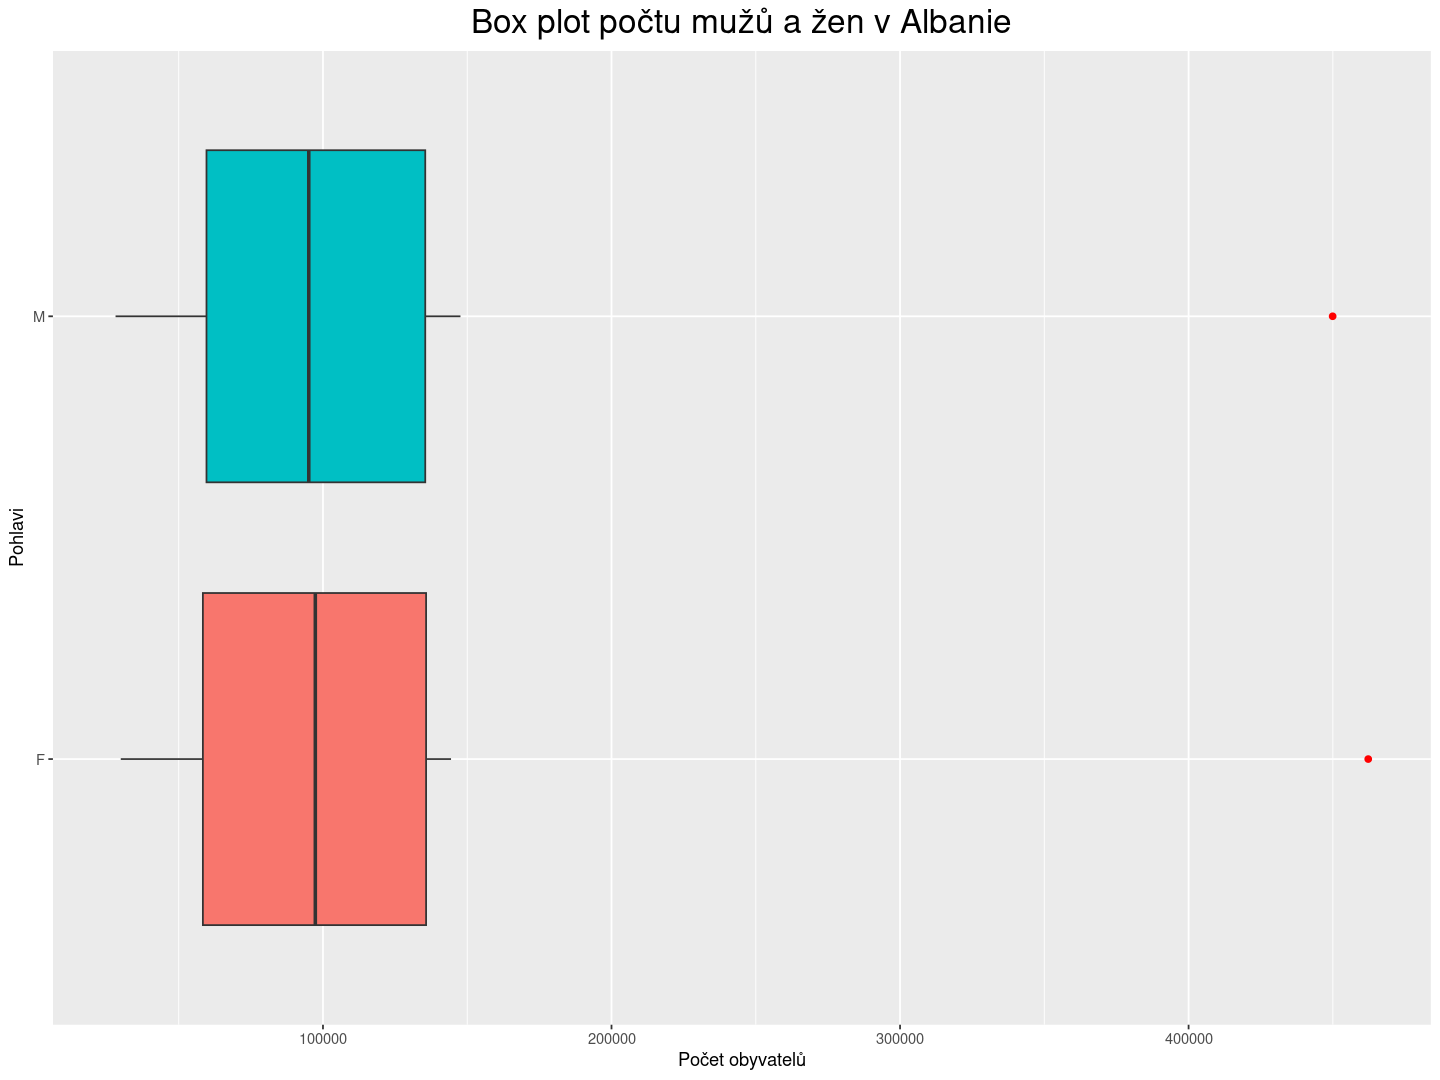

In [15]:
p1 <- ggplot(dat_al_total, aes(x=values, y=sex, fill=sex)) + 
        geom_boxplot(outlier.color="red", show.legend=F) +
        labs(x = "Počet obyvatelů", y = "Pohlavi", title = "Box plot počtu mužů a žen v Albanie")+
        theme(plot.title = element_text(size = 20, hjust = 0.5))

p1

Nakreslíme violin plot.

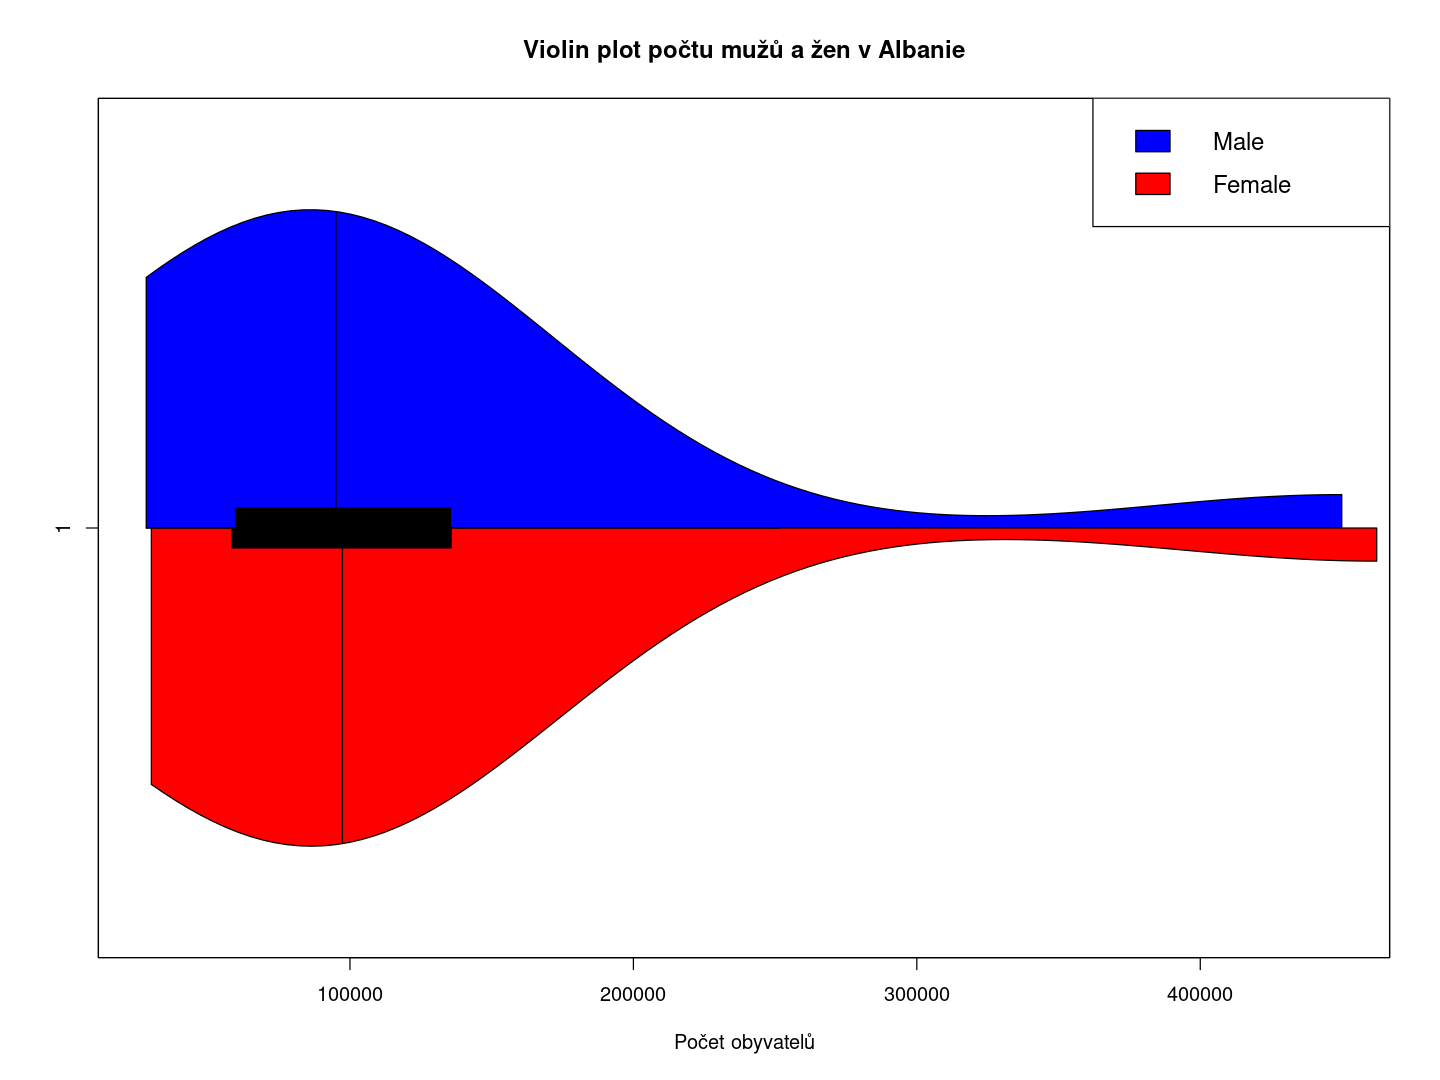

In [16]:
M<- dat_al_total[dat_al_total$sex == 'M', ]
F <- dat_al_total[dat_al_total$sex == 'F', ]

vioplot(as.numeric(M$values), side = "right", plotCentre = "line", col = 'blue', horizontal = TRUE,
        xlab='Počet obyvatelů', main='Violin plot počtu mužů a žen v Albanie')      

vioplot(as.numeric(F$values), side = "left", plotCentre = "line", col ='red', horizontal = TRUE, add = TRUE)       


legend("topright", legend = c("Male", "Female"), fill = c('blue', 'red'), cex = 1.2)

* Z grafů si také můžeme všimnout, že máme jednu odlehlou hodnotu. 
* Z violin plotu lze předpokládat, že data nepocházejí z normálního rozdělení.

Pro jistotu si zkontrolujeme, že region "Tirana" je skutečně hlavním městem Albánie a že tam žije nejvíce obyvatel.

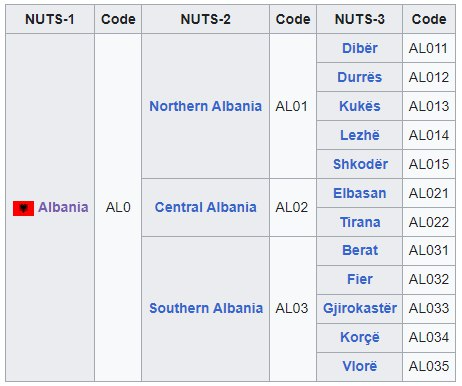

In [17]:
paste('max M :', max(dat_al_total[dat_al_total$sex=='M',]$values))
paste('max F :', max(dat_al_total[dat_al_total$sex=='F',]$values))
dat_al_total[dat_al_total$geo == 'AL022',]

[1] "max M : 449929"

[1] "max F : 462261"

sex,geo,values
<fct>,<fct>,<dbl>
F,AL022,462261
M,AL022,449929


## ÚLOHA 2

### Test 1. Test normality dat.

Nejprve si nakreslíme Q-Q plot.

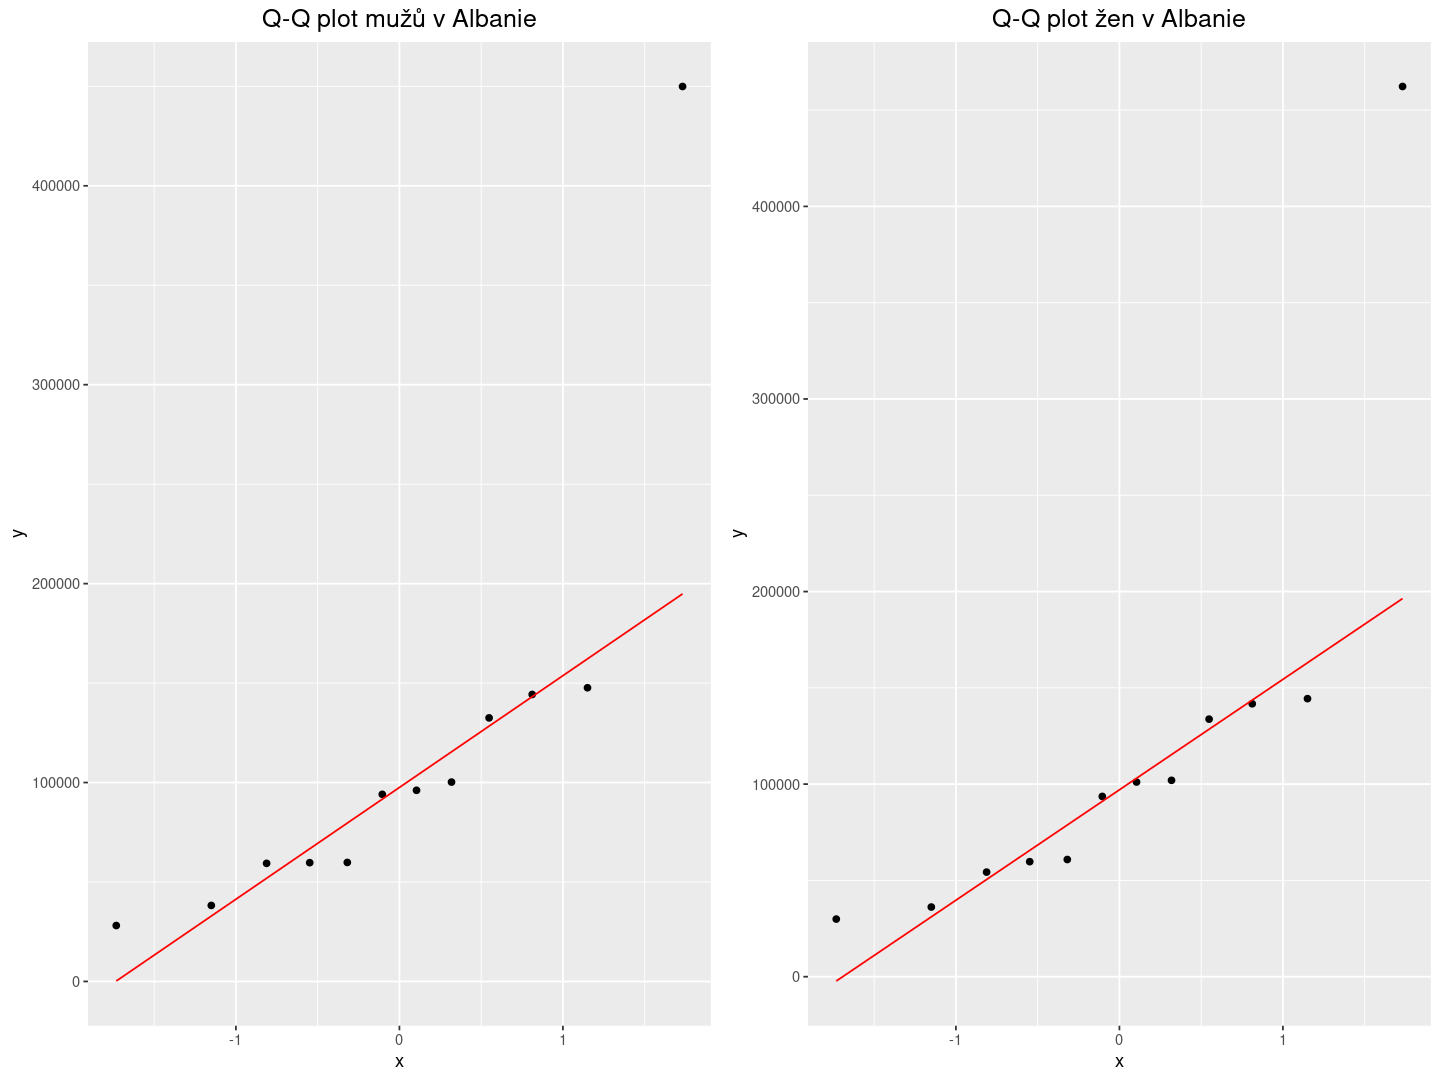

In [18]:
qq_m <- ggplot(dat_al_m, aes(sample=values)) +
            stat_qq(distribution=qnorm) +
            stat_qq_line(distribution=qnorm, col='red')+
            labs(title = "Q-Q plot mužů v Albanie")+
            theme(plot.title = element_text(size = 15, hjust = 0.5))

qq_f <- ggplot(dat_al_f, aes(sample=values)) +
            stat_qq(distribution=qnorm) +
            stat_qq_line(distribution=qnorm, col='red')+
            labs(title = "Q-Q plot žen v Albanie")+
            theme(plot.title = element_text(size = 15, hjust = 0.5))
plot_grid(qq_m, qq_f)

Z Q-Q plotu také předpokládáme, že data nejsou normálně rozdělena.

Pro ověření našého předpokládu použijeme **Shapirův-Wilkův** test, který je vhodný pro malé a středně velké vzorky a je výkonnější než test Kolmogorova-Smirnova.
Proto provedeme **Shapirův-Wilkův** test na hladině významnosti 5 % pro testování hypotézy, zda naše data pocházejí z normálního rozdělení.
 

Tento test normality používáme k ověření, zda můžeme nadále používat statistické metody, které předpokládají normální rozdělení dat.

- $H_0$: $X_1,\ldots, X_n$ je výběr z normálního rozdělení, kde $X_1,\ldots, X_n$ = výběr mužů
- $H_A$: neplatí $H_0$

- $H_0$: $X_1,\ldots, X_n$ je výběr z normálního rozdělení, kde $X_1,\ldots, X_n$ = výběr žen
- $H_A$: neplatí $H_0$

In [19]:
shapiro.test(dat_al_total[dat_al_total$sex == 'F',]$values)


	Shapiro-Wilk normality test

data:  dat_al_total[dat_al_total$sex == "F", ]$values
W = 0.65229, p-value = 0.0003037


In [20]:
shapiro.test(dat_al_total[dat_al_total$sex == 'M',]$values)


	Shapiro-Wilk normality test

data:  dat_al_total[dat_al_total$sex == "M", ]$values
W = 0.66353, p-value = 0.0003837


Závěr pro test pro muži:
* P-hodnota je menší než 5%, **zamítáme** nulovou hypotézu.
* Nemůžeme předpokládat, že naše data pocházejí z normálního rozdělení. Proto nemůžeme v budoucnu používat testy, které vyžadují tento předpoklad.

Závěr pro test pro ženy:
* P-hodnota je menší než 5%, **zamítáme** nulovou hypotézu.
* Nemůžeme předpokládat, že naše data pocházejí z normálního rozdělení. Proto nemůžeme v budoucnu používat testy, které vyžadují tento předpoklad.

### Test 2. Test shody distibucí.

Z grafů jsme si všimli, že muži a ženy mají skoro stejné rozdělení, nyní to otestujeme na hladině významnosti 5 %. Pro tento účel jsme zvolili **Wilcoxon signed-rank test**. Zvolili jsme tento test, protože máme párové výběry, u kterých jsme na základě provedeného výše testu předpokládali, že nejsou normálně rozdělené.

Předpokládáme, že oba výběry pocházejí ze stejného spojitého rozdělení. Testujeme hypotézu.

- $H_0$: Mediánový rozdíl mezi párovými vzorky je nulový. To znamená, že rozdíly mezi páry jsou rovnoměrně rozloženy kolem nuly.
- $H_A$: neplatí $H_0$.

In [21]:
wilcox.test(M$values, F$values, paired=TRUE)


	Wilcoxon signed rank exact test

data:  M$values and F$values
V = 37, p-value = 0.9097
alternative hypothesis: true location shift is not equal to 0


Závěr:
* P-hodnota je větši než 5%, proto **nezamitáme** nulovou hypotézu.
* Můžeme předpokládat, že oba výběrý pocházejí ze stejného spojitého rozdělení.

### Test 3. Test shody medianu s medianem NUTS3 Evropské unie. 
Zajímá nás, zda je medián počtu obyvatel regionů v Albánii stejný jako medián počtu obyvatel mezi všemi regiony celé Evropské unie. 
 
Pro tento účel použijeme jednovýběrový Wilcoxonův znaménkový test na hladině významnosti 5%. Zvolili jsme tento test, protože je speciálně určen pro porovnávání, zda medián našeho výběru se liší od mediánu všech regionů EU.

Budeme testovat hypotézu, kde $x_a$ je medián počtu obyvatel regionů v Albánii a $x_c$ je medián počtu obyvatel mezi všemi regiony EU.

- $H_0$: $x_a = x_c$
- $H_A$: $x_a \ne x_c$

Najdeme median v roku '2021-01-01' pro muže a ženy a pro věk = "Total" mezi všemi regiony celoevropské unie.

In [22]:
dat_eu <- dat[dat$time == "2021-01-01" & nchar(dat$geo) == 5 & dat$sex %in% c("F", "M") & dat$age == "TOTAL",]
dat_eu$sex <- factor(dat_eu$sex)
dat_eu$geo <- factor(dat_eu$geo)
dat_eu$unit <- NULL
dat_eu$time <- NULL
dat_eu$age <- NULL
eu_median <- median(dat_eu$values)
paste("Median z celoevropského rámce : ", eu_median)

[1] "Median z celoevropského rámce :  130096"

In [23]:
wilcox.test(x=dat_al_total$values, mu=eu_median)


	Wilcoxon signed rank exact test

data:  dat_al_total$values
V = 68, p-value = 0.01787
alternative hypothesis: true location is not equal to 130096


P-hodnota je menší než 5%, proto **zamitáme** nulovou hypotézu.
Předpokladáme, že medián našeho výběru je významně odlišný od mediánu všech regionů Evropské unie.

## ÚLOHA 3
> Sestavte kontingenční tabulku počtů obyvatel podle pohlaví a NUTS 3 oblastí. Tuto tabulku interpretujte, navrhněte hypotézy o jejích vlastnostech a proveďte příslušný test. Interpretujte jeho výsledky.


Sestavíme kontingenční tabulku a matici pravděpodobnosti (*regiony* x *pohlaví*), které popisují vztah dvou příznaků rozdělených do kategorií.

In [24]:
dat_al_table <- xtabs(formula = values ~ sex + geo, data=dat_al_total)
addmargins(dat_al_table)

dat_al_proptable <- prop.table(dat_al_table)
addmargins(dat_al_proptable)

,AL011,AL012,AL013,AL014,AL015,AL021,AL022,AL031,AL032,AL033,AL034,AL035,Sum
F,54311,144381,36175,60852,101080,133744,462261,59735,141721,29919,101965,93615,1419759
M,59372,147648,38213,59826,96097,132501,449929,59715,144281,28112,100228,94060,1409982
Sum,113683,292029,74388,120678,197177,266245,912190,119450,286002,58031,202193,187675,2829741


,AL011,AL012,AL013,AL014,AL015,AL021,AL022,AL031,AL032,AL033,AL034,AL035,Sum
F,0.01919292,0.05102269,0.01278386,0.02150444,0.03572058,0.04726369,0.1633581,0.02110971,0.05008268,0.010573052,0.03603333,0.03308253,0.5017275
M,0.02098143,0.05217721,0.01350406,0.02114186,0.03395965,0.04682443,0.1590001,0.02110264,0.05098735,0.009934478,0.03541950,0.03323979,0.4982725
Sum,0.04017435,0.10319990,0.02628792,0.04264631,0.06968023,0.09408812,0.3223581,0.04221234,0.10107003,0.020507531,0.07145283,0.06632232,1.0000000


Pro snadné pochopení kontingenční tabulky si nakreslíme mosaic plot.

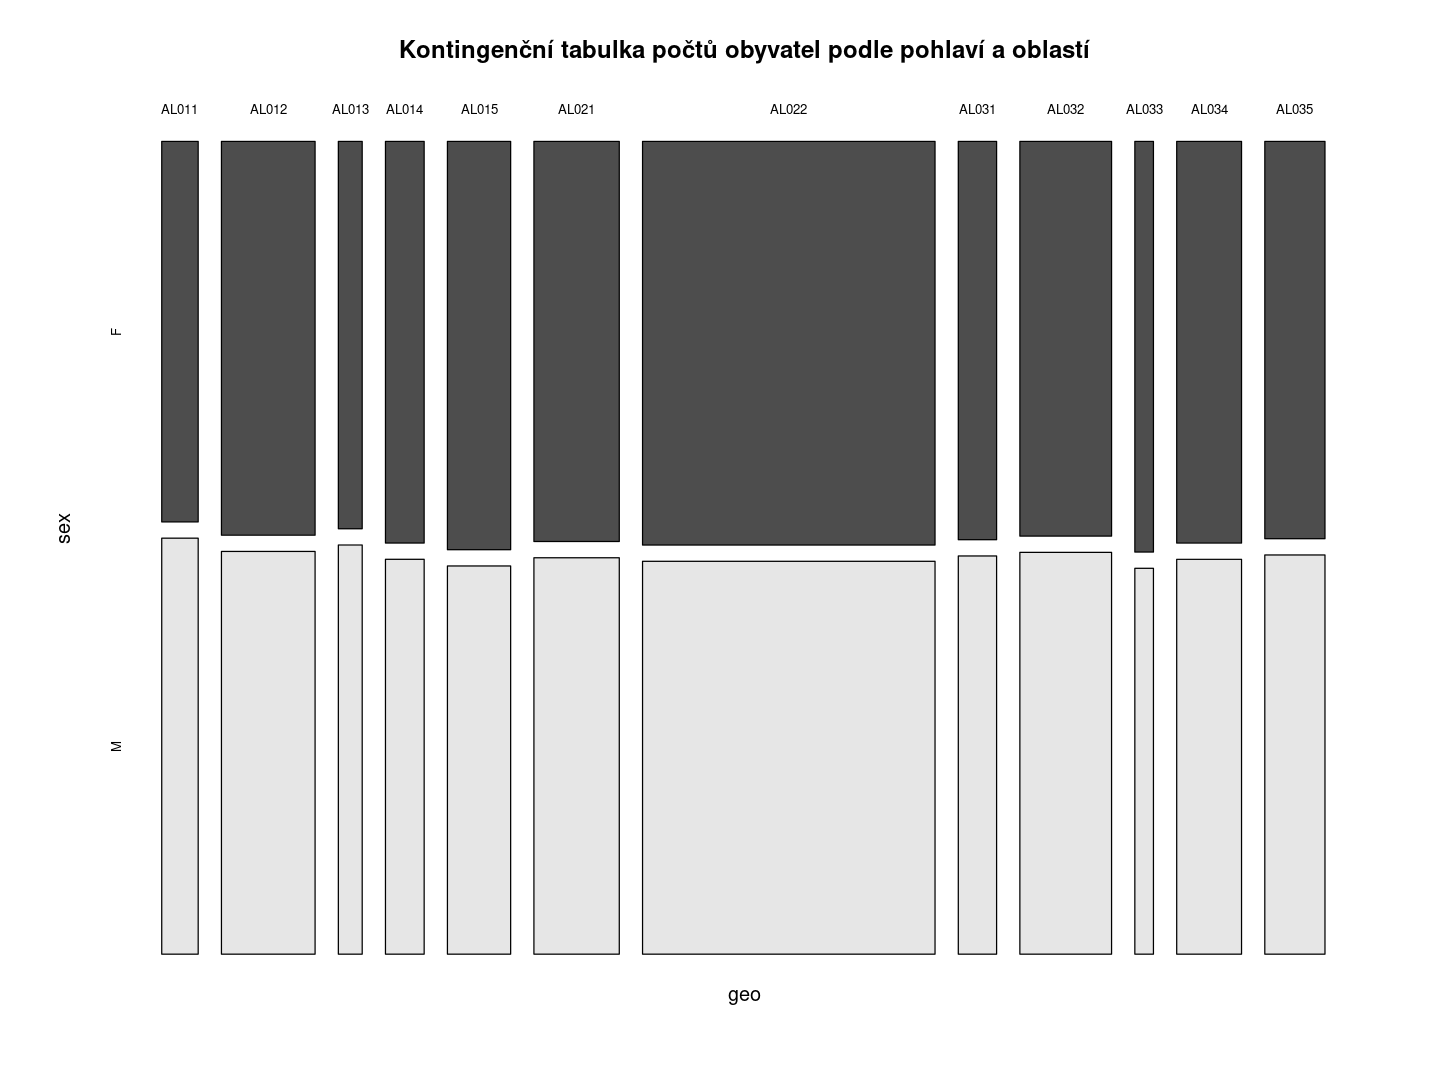

In [25]:
mosaicplot(t(dat_al_table), color=T, main = "Kontingenční tabulka počtů obyvatel podle pohlaví a oblastí")

Z tohoto grafu je také vidět, že máme stejné poměry mužů a žen v každém regionu Albánie. Očekávaně má AL022 (region hlavního města) největší počet obyvatel.

### Pearsonův $\chi^2$ test nezávislosti

Testujeme, zda pravděpodobnosti $p_{i1},\ldots,p_{ic}$ jsou **nezávislé** na řádkovém indexu na hladině významnosti 5%. Pro náš dataset platí, že pro všechna (𝑖,𝑗) jsou teoretické četnosti $\frac{n_{i\cdot} n_{\cdot j}}{n}\geq 5$.

- $H_0$:  $p_{ij} = p_{i\cdot} p_{\cdot j}, \qquad i=1,\ldots,r; j=1,\ldots, c$
- $H_A$: neplatí $H_0$

In [26]:
pears <- chisq.test (dat_al_table)
pears



	Pearson's Chi-squared test

data:  dat_al_table
X-squared = 686.26, df = 11, p-value < 0.00000000000000022


P-hodnota je menší než 5%, proto **zamitáme** nulovou hypotézu.
Předpokladáme, že existuje statisticky významná vazba mezi pohlaví a regiony.

Můžeme snadno spočítat, jaké byly očekávané četnosti v případě nezávislosti. Pozorované četnosti jsou:

In [27]:
addmargins(pears$expected)

,AL011,AL012,AL013,AL014,AL015,AL021,AL022,AL031,AL032,AL033,AL034,AL035,Sum
F,57037.89,146519,37322.51,60547.48,98929.13,133582.4,457670.8,59931.36,143495.1,29115.75,101445.8,94161.72,1419759
M,56645.11,145510,37065.49,60130.52,98247.87,132662.6,454519.2,59518.64,142506.9,28915.25,100747.2,93513.28,1409982
Sum,113683.00,292029,74388.00,120678.00,197177.00,266245.0,912190.0,119450.00,286002.0,58031.00,202193.0,187675.00,2829741


Spočítáme rozdíl mezi očekávanými a skutečnými hodnotami.

In [28]:
addmargins(pears$expected - pears$observed)

,AL011,AL012,AL013,AL014,AL015,AL021,AL022,AL031,AL032,AL033,AL034,AL035,Sum
F,2726.892,2137.993,1147.508,-304.5235,-2150.868,-161.5502,-4590.152,196.355,1774.081,-803.2489,-519.2028,546.7167,0.000000000007275958
M,-2726.892,-2137.993,-1147.508,304.5235,2150.868,161.5502,4590.152,-196.355,-1774.081,803.2489,519.2028,-546.7167,-0.000000000007275958
Sum,0.000,0.000,0.000,0.0000,0.000,0.0000,0.000,0.000,0.000,0.0000,0.0000,0.0000,0.000000000000000000


Je to vše :)